In [1]:
from datetime import datetime, timedelta
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import json
import os

In [2]:
BIGQUERY_PROJECT_NAME = 'oso-data-436717'

# define selected project
PROJECT_NAME = 'Ether.fi OP Mainnet LRT Grant'
PROJECT_START_DATE = '2024-09-01'
PROJECT_NETWORK = 'mainnet'

In [3]:
with open("s6/data/grant_metrics_reviewed.json", "r") as f:
    grant_metrics = json.load(f)

project_grant_metrics = [project['metrics'] for project in grant_metrics if project['project_name'] == PROJECT_NAME]
pprint.pprint(project_grant_metrics[0])

{'OP request Locked': '24000',
 'OP request for User Incentives': '96000',
 'TVL in grantee’s protocol': '5000 weETH of TVL added to the OP Mainnet '
                              'ecosystem'}


In [4]:
with open("s6/data/updated_grants_reviewed.json", "r") as f:
    grants = json.load(f)

project_address_dict = [project['addresses'] for project in grants if project['project_name'] == PROJECT_NAME][0]
pprint.pprint(project_address_dict)

project_addresses = []
for address in project_address_dict:
    project_addresses.extend(list(address.keys()))
project_addresses = tuple(project_addresses)
print(project_addresses)

[{'0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42': {'count_txns': 0,
                                                 'name': 'etherfi',
                                                 'networks': ['optimism'],
                                                 'tags': ['eoa', 'wallet']}},
 {'0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff': {'count_txns': 1919,
                                                 'name': 'etherfi',
                                                 'networks': ['optimism'],
                                                 'tags': ['contract']}},
 {'0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42': {'count_txns': 0,
                                                 'name': 'etherfi',
                                                 'networks': ['optimism'],
                                                 'tags': ['eoa', 'wallet']}},
 {'0xd0f92f5d756bf223574dfa3ef284a35c3c046289': {'count_txns': 46,
                                                 'name': 'etherfi',
      

In [5]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
client = bigquery.Client(BIGQUERY_PROJECT_NAME)

In [6]:
# daily transactions
daily_transactions_query = f"""
    SELECT 
        dt AS transaction_date,
        to_address AS contract_address,
        COUNT(*) AS transaction_cnt,
        COUNT(from_address) AS active_users,
        COUNT(DISTINCT from_address) AS unique_users,
        SUM(value_64) AS total_op_transferred
    FROM `{BIGQUERY_PROJECT_NAME}.optimism_superchain_raw_onchain_data.transactions` 
    WHERE to_address IN {project_addresses}
        AND network = '{PROJECT_NETWORK}'
        AND dt >= '{PROJECT_START_DATE}'
    GROUP BY dt, to_address
    ORDER BY dt, to_address"""

In [7]:
daily_transactions_result = client.query(daily_transactions_query)
daily_transactions_df = daily_transactions_result.to_dataframe()

/Users/evanmeyer/Desktop/work/kariba-labs/insights/analysis/optimism/govfund_grants/env/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [8]:
dates = []
todays_date = datetime.now()
target_date = datetime(2024, 9, 1)
date_interval = (todays_date - target_date).days
for i in range(date_interval):
    date = target_date + timedelta(days=i)
    dates.append(date.strftime("%Y-%m-%d"))

data = []
for address in project_addresses:
    for date in dates:
        data.append({'transaction_date': date, 'contract_address': address})

dates_df = pd.DataFrame(data)

In [9]:
dates_df

,transaction_date,contract_address
0,2024-09-01,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42
1,2024-09-02,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42
2,2024-09-03,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42
3,2024-09-04,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42
4,2024-09-05,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42
...,...,...
411,2024-12-09,0xd0f92f5d756bf223574dfa3ef284a35c3c046289
412,2024-12-10,0xd0f92f5d756bf223574dfa3ef284a35c3c046289
413,2024-12-11,0xd0f92f5d756bf223574dfa3ef284a35c3c046289
414,2024-12-12,0xd0f92f5d756bf223574dfa3ef284a35c3c046289


In [10]:
daily_transactions_merged_df = pd.merge(daily_transactions_df, dates_df, how='outer', on=['transaction_date', 'contract_address']).fillna(0) 
numeric_cols = ['transaction_cnt', 'active_users', 'unique_users', 'total_op_transferred']
daily_transactions_merged_df[numeric_cols] = daily_transactions_merged_df[numeric_cols].astype(int)

daily_transactions_merged_df = (daily_transactions_merged_df
    .groupby(['transaction_date', 'contract_address'], as_index=False)
    .agg({
        'transaction_cnt': 'sum',
        'active_users': 'sum',
        'unique_users': 'sum',
        'total_op_transferred': 'sum'
    })
)

In [11]:
daily_transactions_merged_df

,transaction_date,contract_address,transaction_cnt,active_users,unique_users,total_op_transferred
0,2024-09-01,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,6,6,6,0
1,2024-09-02,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,10,10,10,1133448406663631
2,2024-09-03,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,33,33,17,1088494405695725
3,2024-09-04,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,13,13,7,1362407221635313
4,2024-09-05,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,8,8,7,14724642785811230
...,...,...,...,...,...,...
442,2024-12-12,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42,0,0,0,0
443,2024-12-12,0xd0f92f5d756bf223574dfa3ef284a35c3c046289,0,0,0,0
444,2024-12-13,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,0,0,0,0
445,2024-12-13,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42,0,0,0,0


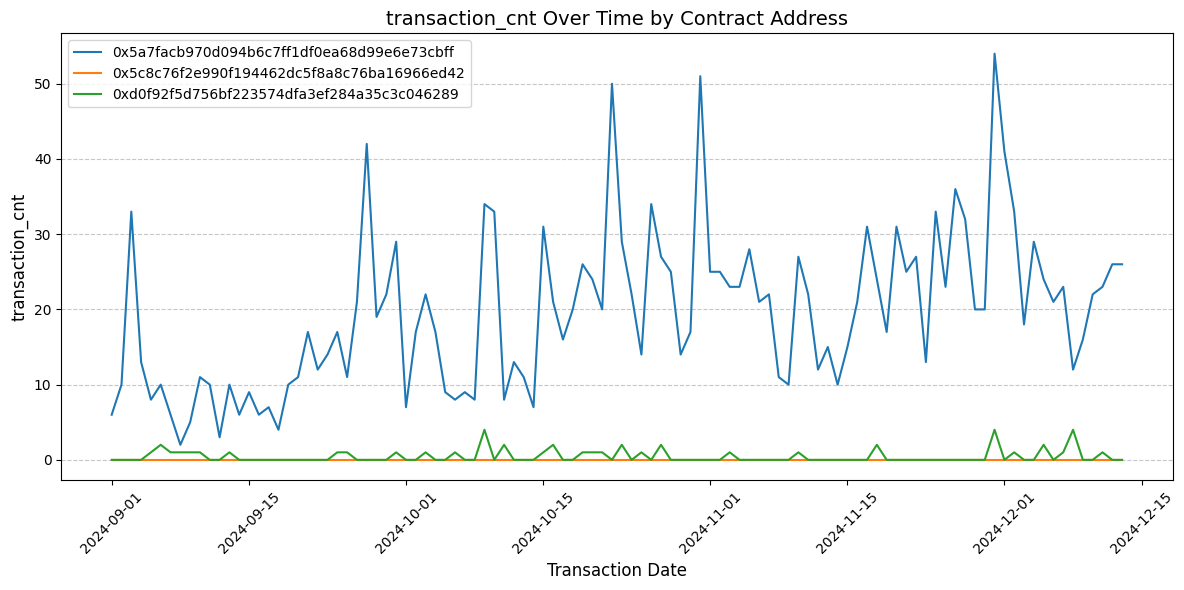

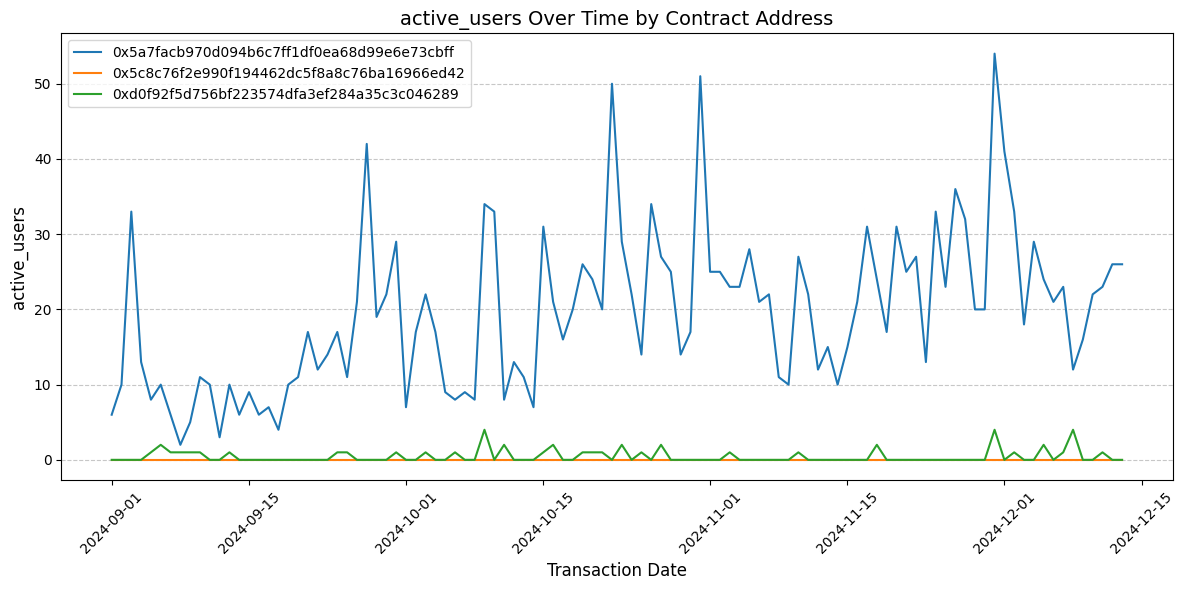

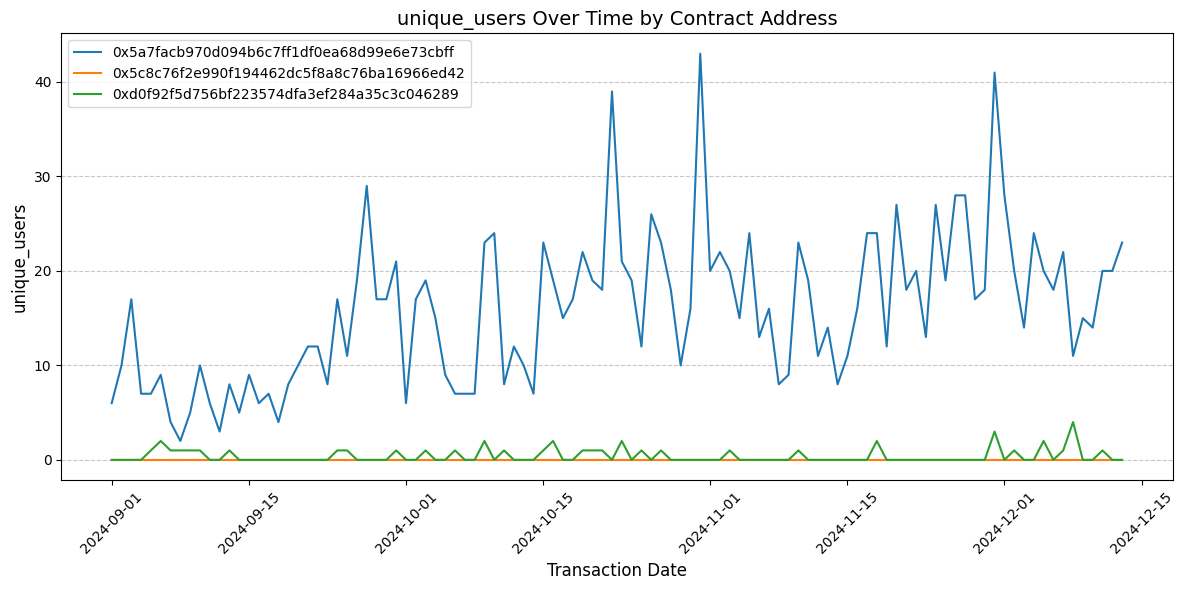

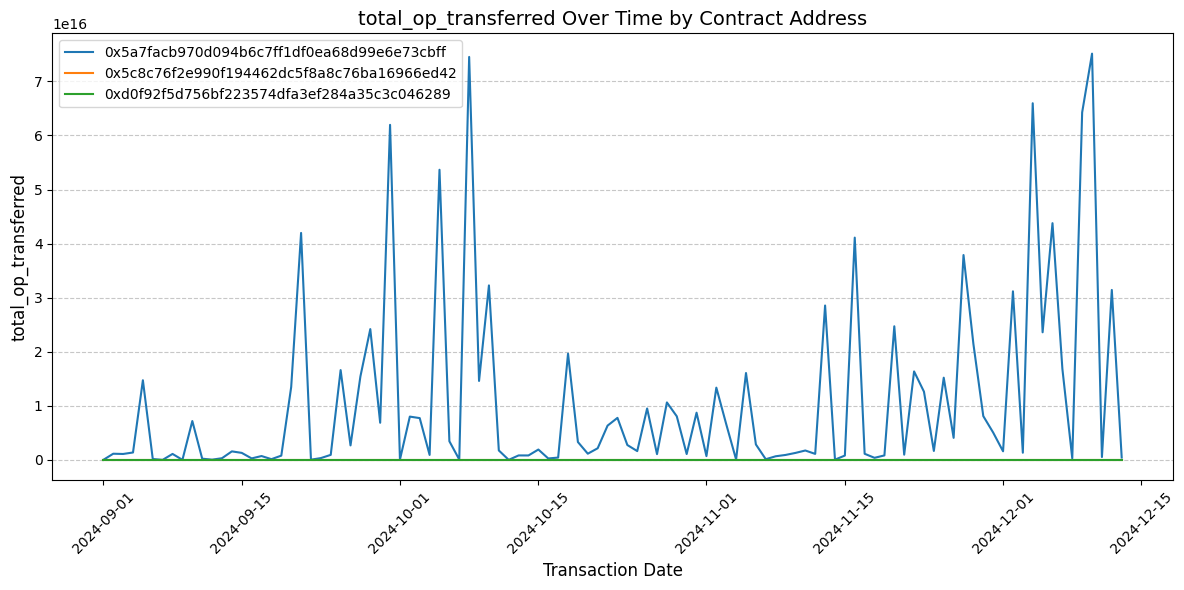

In [12]:
for target_column in numeric_cols:
    daily_transactions_merged_df['transaction_date'] = pd.to_datetime(daily_transactions_merged_df['transaction_date'])
    data_grouped = daily_transactions_merged_df.groupby(['transaction_date', 'contract_address'])[target_column].sum().reset_index()
    data_grouped = data_grouped.sort_values('transaction_date').reset_index(drop=True)

    pivoted_data = data_grouped.pivot(
        index='transaction_date', 
        columns='contract_address', 
        values=target_column
    )

    plt.figure(figsize=(12, 6))

    for contract in pivoted_data.columns:
        plt.plot(pivoted_data.index, pivoted_data[contract], label=contract)

    plt.title(f'{target_column} Over Time by Contract Address', fontsize=14)
    plt.xlabel('Transaction Date', fontsize=12)
    plt.ylabel(f'{target_column}', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'metrics/{target_column}_by_contract_linegraph.png')
    plt.show()

In [13]:
# op flow
op_flow_query = f"""
    (SELECT 
        dt AS transaction_date,
        from_address,
        to_address,
        COUNT(*) AS cnt,
        SUM(value_64) AS total_op_transferred
    FROM `{BIGQUERY_PROJECT_NAME}.optimism_superchain_raw_onchain_data.transactions`
    WHERE network = '{PROJECT_NETWORK}'
        AND to_address IN {project_addresses}
        AND dt >= '{PROJECT_START_DATE}'
    GROUP BY dt, from_address, to_address
    ORDER BY 3 DESC)

    UNION ALL 

    (SELECT 
        dt AS transaction_date,
        from_address,
        to_address,
        COUNT(*) AS cnt,
        SUM(value_64) AS total_op_transferred
    FROM `oso-data-436717.optimism_superchain_raw_onchain_data.transactions`
    WHERE network = '{PROJECT_NETWORK}'
        AND from_address IN {project_addresses}
        AND dt >= '{PROJECT_START_DATE}'
    GROUP BY dt, from_address, to_address
    ORDER BY 3 DESC)"""

In [14]:
op_flow_result = client.query(op_flow_query)
op_flow_df = op_flow_result.to_dataframe()

/Users/evanmeyer/Desktop/work/kariba-labs/insights/analysis/optimism/govfund_grants/env/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [15]:
op_flow_df

,transaction_date,from_address,to_address,cnt,total_op_transferred
0,2024-10-12,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42,0x4200000000000000000000000000000000000042,1,0
1,2024-10-22,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42,0x8184be1bdad8c6861d2e134ec492827d5058fb2b,3,0
2,2024-11-11,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42,0xa18156859afaeb67ead68d32e4ba1c01fedc7ae8,1,0
3,2024-11-26,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42,0xcf77a3ba9a5ca399b7c97c74d54e5b1beb874e43,1,0
4,2024-11-26,0x5c8c76f2e990f194462dc5f8a8c76ba16966ed42,0x04c0599ae5a44757c0af6f9ec3b93da8976c150a,1,0
...,...,...,...,...,...
1714,2024-11-21,0xa913b7666d2b554c6bacd3c4f4875dade813baba,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,1,247328383871879
1715,2024-11-02,0x8ded83b21347a23779004eba17c6c1ee3a62f6d5,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,1,0
1716,2024-09-02,0x88a08d6ae2833c5929c10188c666efb266a2a8da,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,1,216413971435845
1717,2024-10-28,0x6d2f2014f26fd359e9f02928c6f55fd3a5de1996,0x5a7facb970d094b6c7ff1df0ea68d99e6e73cbff,1,0


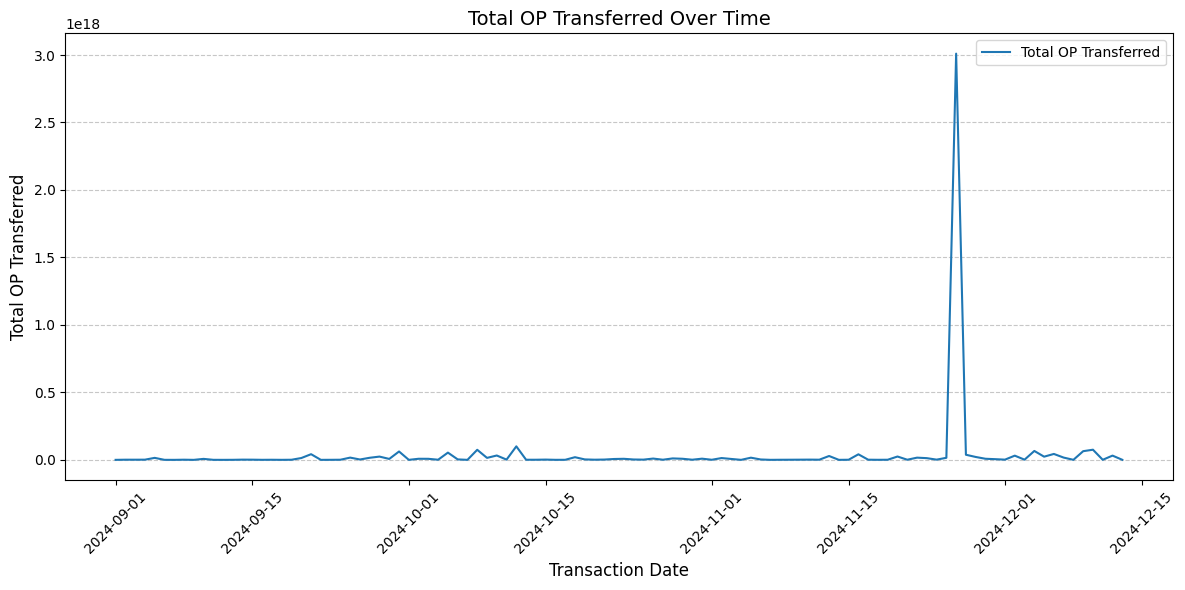

In [16]:
op_flow_df['transaction_date'] = pd.to_datetime(op_flow_df['transaction_date'])

daily_totals = op_flow_df.groupby('transaction_date')['total_op_transferred'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_totals.index, daily_totals.values, label='Total OP Transferred')

plt.title('Total OP Transferred Over Time', fontsize=14)
plt.xlabel('Transaction Date', fontsize=12)
plt.ylabel('Total OP Transferred', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('metrics/total_op_transferred_linechart.png')
plt.show()

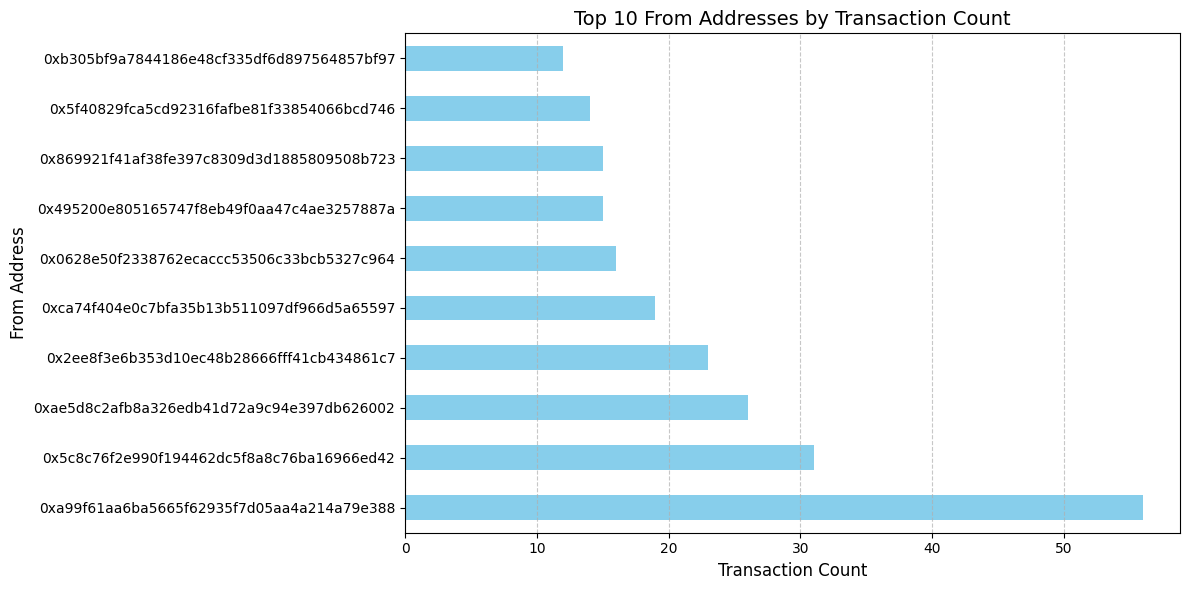

In [17]:
address_counts = op_flow_df.groupby('from_address')['cnt'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
address_counts.head(10).plot(kind='barh', color='skyblue')

plt.title('Top 10 From Addresses by Transaction Count', fontsize=14)
plt.xlabel('Transaction Count', fontsize=12) 
plt.ylabel('From Address', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  
plt.tight_layout()
plt.savefig('metrics/top_addresses_by_trans_cnt_barchart.png')
plt.show()